In [21]:
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

import pandas as pd

from google.colab import files

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 

import numpy as np

# загрузка данных

https://www.kaggle.com/datasets/gauravduttakiit/loan-defaulter/code?datasetId=807638&sortBy=voteCount

### предподготовка к загрузке датасетов

In [22]:
# загрузка kaggle API в файле "kaggle.json"
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"denzelito","key":"4b227ee6e6f444ec6821c7cd9ee1b3de"}'}

In [23]:
# проверка актуальности загруженного API
!ls -lha kaggle.json

-rw-r--r-- 1 root root 65 May  2 20:05 kaggle.json


In [24]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [25]:
# принт списка доступных датасетов
!kaggle datasets list

ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/date-fruit-datasets                                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39           4035        688  0.9375           
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset                  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36            610        609  0.9375           
datasets/muratkokludataset/pistachio-dataset                                   Pistachio Dataset                                  2MB  2022-04-03 08:38:21            388        536  0.9375           


In [26]:
# поиск необходимого датасета
!kaggle datasets list -s loan

ref                                                                      title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/zhijinzhai/loandata                                             Loan  Data                                    5KB  2017-04-11 02:22:09          16970        245  0.8235294        
datasets/itssuru/loan-data                                               Loan Data                                   213KB  2021-05-14 19:38:51           3324         79  1.0              
datasets/gauravduttakiit/loan-defaulter                                  Loan Defaulter                              112MB  2020-07-30 18:32:38           6186         91  0.85294116       
datasets/ninzaami/loan-predication                     

In [27]:
# загрузка датасета
!kaggle datasets download -d gauravduttakiit/loan-defaulter 

loan-defaulter.zip: Skipping, found more recently modified local copy (use --force to force download)


In [28]:
# список файлов в директории
!ls

 application_data.csv	   kaggle.json		      sample_data
 columns_description.csv   loan-defaulter.zip
'kaggle (1).json'	   previous_application.csv


In [29]:
# разархивирование
!unzip loan-defaulter.zip

Archive:  loan-defaulter.zip
replace application_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace columns_description.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace previous_application.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [30]:
# список файлов в директории
!ls

 application_data.csv	   kaggle.json		      sample_data
 columns_description.csv   loan-defaulter.zip
'kaggle (1).json'	   previous_application.csv


### загрузка датасетов

In [31]:
print('application_df')
application_df = pd.read_csv('application_data.csv')
print(application_df.shape)
display(application_df.head(3))

print('previous_df')
previous_df = pd.read_csv('previous_application.csv')
print(previous_df.shape)
display(previous_df.head(3))

application_df
(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


previous_df
(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0


# анализ данных (EDA - exploratory data analysis) + удаление полей

### размерность

In [32]:
print('application_df')
print(application_df.shape)

print('\nprevious_df')
print(previous_df.shape)

application_df
(307511, 122)

previous_df
(1670214, 37)


### типы данных

In [33]:
application_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [34]:
previous_df.dtypes.value_counts()

object     16
float64    15
int64       6
dtype: int64

In [35]:
application_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [36]:
previous_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

### статистика числовых данных

In [37]:
application_df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [38]:
previous_df.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


### кол-во пропусков

In [39]:
app_miss_df = round(application_df.isnull().sum() / application_df.shape[0] * 100.00,2)
app_miss_df = app_miss_df[app_miss_df > 50]

print('кол-во фич',len(app_miss_df),'\n')
app_miss_df.sort_values(ascending=False)

кол-во фич 41 



COMMONAREA_AVG              69.87
COMMONAREA_MEDI             69.87
COMMONAREA_MODE             69.87
NONLIVINGAPARTMENTS_MEDI    69.43
NONLIVINGAPARTMENTS_AVG     69.43
NONLIVINGAPARTMENTS_MODE    69.43
FONDKAPREMONT_MODE          68.39
LIVINGAPARTMENTS_MEDI       68.35
LIVINGAPARTMENTS_AVG        68.35
LIVINGAPARTMENTS_MODE       68.35
FLOORSMIN_MODE              67.85
FLOORSMIN_MEDI              67.85
FLOORSMIN_AVG               67.85
YEARS_BUILD_MODE            66.50
YEARS_BUILD_AVG             66.50
YEARS_BUILD_MEDI            66.50
OWN_CAR_AGE                 65.99
LANDAREA_AVG                59.38
LANDAREA_MEDI               59.38
LANDAREA_MODE               59.38
BASEMENTAREA_MEDI           58.52
BASEMENTAREA_AVG            58.52
BASEMENTAREA_MODE           58.52
EXT_SOURCE_1                56.38
NONLIVINGAREA_MODE          55.18
NONLIVINGAREA_MEDI          55.18
NONLIVINGAREA_AVG           55.18
ELEVATORS_MODE              53.30
ELEVATORS_MEDI              53.30
ELEVATORS_AVG 

In [40]:
prv_miss_df = round(previous_df.isnull().sum() / previous_df.shape[0] * 100.00,2)
prv_miss_df = prv_miss_df[prv_miss_df > 50]
print('кол-во фич',len(prv_miss_df),'\n')
prv_miss_df.sort_values(ascending=False)

кол-во фич 4 



RATE_INTEREST_PRIMARY       99.64
RATE_INTEREST_PRIVILEGED    99.64
AMT_DOWN_PAYMENT            53.64
RATE_DOWN_PAYMENT           53.64
dtype: float64

In [41]:
# удаление полей с большой долей пропусков
application_df.drop(columns=app_miss_df.index.tolist(),inplace=True)
previous_df.drop(columns=prv_miss_df.index.tolist(),inplace=True)

### проверка доли значений в бинарных полях 

In [42]:
bad_columns = []
for i in application_df.drop(columns='TARGET').columns:
  if len(application_df[i].value_counts())==2:
    values = application_df[i].unique()
    a1 = len(application_df[application_df[i]==values[0]])
    a2 = len(application_df[application_df[i]==values[1]])

    if min([a1,a2]) / max([a1,a2]) < 0.001:
      print(i)
      bad_columns.append(i)

application_df.drop(columns=bad_columns, inplace=True)

FLAG_MOBIL
EMERGENCYSTATE_MODE
FLAG_DOCUMENT_2
FLAG_DOCUMENT_4
FLAG_DOCUMENT_7
FLAG_DOCUMENT_10
FLAG_DOCUMENT_12
FLAG_DOCUMENT_17
FLAG_DOCUMENT_19
FLAG_DOCUMENT_20
FLAG_DOCUMENT_21


# выделение тестовой выборки

In [43]:
X = application_df.drop(columns=['TARGET'])
y = application_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((246008, 69), (61503, 69), (246008,), (61503,))

In [44]:
# деление previous_df
prv_id_train = X_train['SK_ID_CURR']
prv_id_test = X_test['SK_ID_CURR']

prv_X_train = previous_df[previous_df['SK_ID_CURR'].isin(prv_id_train)]
prv_X_test = previous_df[previous_df['SK_ID_CURR'].isin(prv_id_test)]

In [45]:
print('Распределение ответов на train: ', round(y_train.mean(),2))
print('Распределение ответов на test:  ', round(y_test.mean(),2))

Распределение ответов на train:  0.08
Распределение ответов на test:   0.08


# препроцессинг данных

### типы признаков

In [46]:
#application_df
print('all types: ', X_train.dtypes.unique().tolist())

app_types_df = X_train.dtypes
app_cat_features = app_types_df[(app_types_df==object) | (app_types_df==str)].index.tolist()
app_num_features = X_train.drop(columns=app_cat_features+['SK_ID_CURR']).columns.tolist()



print('cat_features count: ',len(app_cat_features))
print('num_features count: ',len(app_num_features))

all types:  [dtype('int64'), dtype('O'), dtype('float64')]
cat_features count:  12
num_features count:  56


In [47]:
#previous_df
print('all types: ', prv_X_train.dtypes.unique().tolist())

prv_types_df = prv_X_train.dtypes
prv_cat_features = prv_types_df[(prv_types_df==object) | (prv_types_df==str)].index.tolist()
prv_num_features = prv_X_train.drop(columns=prv_cat_features+['SK_ID_CURR','SK_ID_PREV']).columns.tolist()

print('cat_features count: ',len(prv_cat_features))
print('num_features count: ',len(prv_num_features))

all types:  [dtype('int64'), dtype('O'), dtype('float64')]
cat_features count:  16
num_features count:  15


### заполнение пропусков

In [48]:
#application_df
app_fillna_num_values = X_train[app_num_features].median()
for i in app_num_features:
  X_train[i] = X_train[i].fillna(app_fillna_num_values[i])
  X_test[i] = X_test[i].fillna(app_fillna_num_values[i])

for i in app_cat_features:
  X_train[i] = X_train[i].fillna('unknoun')
  X_test[i] = X_test[i].fillna('unknoun')

In [49]:
#previous_df
prv_fillna_num_values = prv_X_train[prv_num_features].median()
for i in prv_num_features:
  prv_X_train[i] = prv_X_train[i].fillna(prv_fillna_num_values[i])
  prv_X_test[i] = prv_X_test[i].fillna(prv_fillna_num_values[i])

for i in prv_cat_features:
  prv_X_train[i] = prv_X_train[i].fillna('unknoun')
  prv_X_test[i] = prv_X_test[i].fillna('unknoun')

### labelencoding для категориальных переменных

In [50]:
#application_df
app_le = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
X_train[app_cat_features] = app_le.fit_transform(X_train[app_cat_features])
X_test[app_cat_features] = app_le.transform(X_test[app_cat_features])

In [51]:
#previous_df
prv_le = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
prv_X_train[prv_cat_features] = prv_le.fit_transform(prv_X_train[prv_cat_features])
prv_X_test[prv_cat_features] = prv_le.transform(prv_X_test[prv_cat_features])

### масштабирование

In [52]:
#application_df
app_scaler = MinMaxScaler()
app_scaler.fit(X_train)
X_train[app_num_features] = app_scaler.fit_transform(X_train[app_num_features])
X_test[app_num_features] = app_scaler.transform(X_test[app_num_features])

In [53]:
#previous_df
prv_scaler = MinMaxScaler()
prv_scaler.fit(X_train)
prv_X_train[prv_num_features] = prv_scaler.fit_transform(prv_X_train[prv_num_features])
prv_X_test[prv_num_features] = prv_scaler.transform(prv_X_test[prv_num_features])

### слияние application_df и previous_df - НЕ ДЕЛАЮ, СТАНОВИТСЯ ХУЖЕ

In [54]:
# print('записи уникальны? -', prv_X_train.SK_ID_PREV.nunique() == len(prv_X_train) )
# prv_X_train.drop(columns='SK_ID_PREV', inplace=True)

# prv_X_train_grp_num = prv_X_train[['SK_ID_CURR']+prv_num_features].groupby('SK_ID_CURR', as_index=False).median()
# prv_X_test_grp_num  = prv_X_train[['SK_ID_CURR']+prv_num_features].groupby('SK_ID_CURR', as_index=False).median()

In [55]:
# данный cell очень долго считается - не используется из-за времени

# prv_X_train_grp_cat = prv_X_train[['SK_ID_CURR']+prv_cat_features].groupby('SK_ID_CURR', as_index=False).max()
# prv_X_test_grp_cat  = prv_X_train[['SK_ID_CURR']+prv_cat_features].groupby('SK_ID_CURR', as_index=False).max()

# prv_X_train_grp = prv_X_train_grp_num.merge(prv_X_train_grp_cat, on='SK_ID_CURR')
# prv_X_test_grp = prv_X_test_grp_num.merge(prv_X_test_grp_cat, on='SK_ID_CURR')

In [56]:
# X_train = X_train.merge(prv_X_train_grp_num, how='left', on='SK_ID_CURR')
# X_test= X_test.merge(prv_X_test_grp_num, how='left', on='SK_ID_CURR')

In [57]:
# # заполнение пропусков после слияния выборок

# for i in prv_num_features:
#   try:
#     X_train[i] = X_train[i].fillna(prv_fillna_num_values[i])
#     X_test[i] = X_test[i].fillna(prv_fillna_num_values[i])
#   except KeyError:
#     continue

### удаление слабокоррелирующих признаков

In [88]:
corr_df = pd.concat([X_train, y_train], axis=1)
corr_df = corr_df.corr()
corr_cols = corr_df['TARGET'][corr_df['TARGET'].abs() > 0.01].index.tolist()
corr_cols.remove('TARGET')
print(len(corr_cols))

44


# нейронка

In [89]:
input_dim = X_train[corr_cols].shape[1]
print(input_dim)

44


In [90]:
class f1_macro_avg(nn.Module):
  def __init__(self):
    super(f1_macro_avg, self).__init__();

  # def forward(self, predictions, target):
  #   actual = y_train_torch
  #   # predicted = torch.where(preds < 0.5, 0, 1)
  #   loss_value = f1_score(actual, preds.round().detach(), average='macro')
  #   return torch.from_numpy(np.array(loss_value))


  def forward(self, predictions, actual):
    # inputs = torch.where(predictions < 0.5, 0, 1)
    inputs = torch.round(predictions)
    
    # ДЛЯ ЕДИНИЦЫ
    correct = torch.mul(inputs, actual)
    correct = torch.sum(correct)
    predicted = torch.sum(inputs)
    truth = torch.sum(actual)
    precision = torch.div(correct, predicted)
    recall = torch.div(correct,truth)
    f1_1 = torch.mul(2, torch.div( torch.mul(precision, recall) , torch.mul(precision, recall) ))

    # ДЛЯ ЕДИНИЦЫ
    actual = torch.where(actual == 1, 0, 1)
    inputs = torch.where(inputs == 1, 0, 1)

    correct = torch.mul(inputs, actual)
    correct = torch.sum(correct)
    predicted = torch.sum(inputs)
    truth = torch.sum(actual)
    precision = torch.div(correct, predicted)
    recall = torch.div(correct,truth)
    f1_0 = torch.mul(2, torch.div( torch.mul(precision, recall) , torch.mul(precision, recall) ))

    f1_ma = torch.add( torch.mul(f1_1,0.5) , torch.mul(f1_0,0.5) )
    return f1_ma

In [97]:
X_train_torch = torch.tensor(X_train[corr_cols].values)
y_train_torch = torch.tensor(y_train.values)
X_test_torch = torch.tensor(X_test[corr_cols].values)
y_test_torch = torch.tensor(y_test.values)

model = torch.nn.Sequential(*[
    nn.Linear(input_dim, 1),
    nn.Sigmoid()
])

# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = f1_macro_avg()
loss_fn.requires_grad= True

optimizer = torch.optim.AdamW(model.parameters(), lr=0.003)

In [99]:
loss_history = []
for epoch in range(100):
    # print(epoch)
    # for X, y in zip(X_train_torch, y_train_torch):

    '''
    В PyTorch нам нужно установить градиенты на ноль,
    прежде чем начинать обратное распространение, поскольку PyTorch 
    накапливает градиенты при последующих обратных проходах.
    '''
    optimizer.zero_grad()
    # прогнозы
    preds = model(X_train_torch.float())
    # потери / transforming {y} to one-hot
    loss = loss_fn(preds, y_train_torch.unsqueeze(1).float())
    # вычисляем потери
    loss.backward()
    # делаем шаг
    optimizer.step()
    # сохраняем loss для визуализации
    loss_history.append(loss.item())

    if epoch%10==0:
      print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 2.0
epoch 10, loss 2.0
epoch 20, loss 2.0
epoch 30, loss 2.0
epoch 40, loss 2.0
epoch 50, loss 2.0
epoch 60, loss 2.0
epoch 70, loss 2.0
epoch 80, loss 2.0
epoch 90, loss 2.0


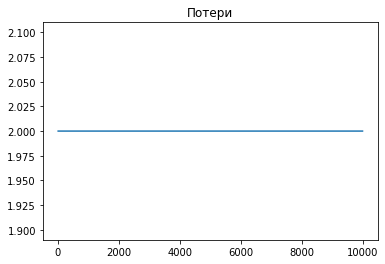

In [93]:
plt.title('Потери')
pd.Series(loss_history).rolling(10).mean().plot()

In [94]:
test_preds = model(X_test_torch.float())
test_preds = torch.argmax(test_preds, axis=1)
test_preds.shape, y_test_torch.shape

(torch.Size([61503]), torch.Size([61503]))

In [95]:
print(classification_report(y_test, test_preds.numpy()))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

